# Эксперимент по вливанию коллекции в тематическую модель

## TL;DR:
* Реализован алгоритм итеративного доливания 20000 документов Habrahabr в ТМ Постнауки;
* Как и в базовом, так и в предлагаемом алгоритме построена плоская ARTM-модель, состоящая из 19 предметных и 1 фоновой темы;
* Модель предлагаемого алгоритма имеет более высокую среднюю когерентность, чем модель базового алгоритма (0.95 против 0.8);
    - Кроме того, количество «подпорченных» Habrahabr'ом тем в первом случае почти в 3 раза меньше, чем во втором (4 против 11);
* Дополнительно, предлагаемый алгоритм был опробован с использованием ранжирования документов по «релевантности» и без него.
    - Эксперимент показал, что ранжирование улучшает качество модели в терминах когерентности (0.95 против 0.92) и количества «подпорченных» тем (4 против 6).

## Исходный код

In [1]:
%matplotlib inline
import os
import sys
import glob
import json
import urllib
import pymongo
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
import artm
import hierarchy_utils

In [6]:
db = pymongo.MongoClient()["datasets"]

In [7]:
prefix_to_col_map = {"pn": "postnauka", "habr": "habrahabr"}

def get_document(doc_id, with_markdown=False):
    fields = {"_id": 1, "title": 1, "modalities": 1}
    if with_markdown:
        fields["markdown"] = 1
    prefix, _ = doc_id.split("_", 1)
    col_name = prefix_to_col_map[prefix]
    return db[col_name].find_one({"_id": doc_id}, fields)

In [8]:
# Шаг 1 -- получение ранжированного списка документов для доливания

reduced_dataset = True
shuffled_dataset = False

docs_ids = list(map(lambda r: r["_id"], db["postnauka"].find({}, {"_id": 1})))

D_a = len(docs_ids)

clf_output = pd.read_csv("classifier_output.csv")
clf_output.columns = ["id", "proba"]
clf_output = clf_output.set_index("id")["proba"]
clf_output = clf_output[clf_output > 0.5]

if reduced_dataset:
    reduced_docs_ids = list(map(str.strip, open("reduced_habr_docs_ids.txt")))
    clf_output = clf_output.loc[reduced_docs_ids].dropna().sort_values(ascending=False)
if shuffled_dataset:
    np.random.seed(42)
    clf_output = clf_output.sample(frac=1)

docs_ids += list(clf_output.index)

D_b = len(docs_ids) - D_a

In [9]:
D_a, D_b

(2976, 4852)

In [10]:
# Шаг 2а -- разбиение списка на батчи для итеративного доливания

# Будем пользоваться законом сложного процента: размер i-ого батча будет считаться как размер (i-1)-ого батча + p%.
# Тогда количество итераций n, необходимых для вливания коллекции размера D_b в коллекцию размера D_a, удовлетворяет:
# D_a * (1 + p)^n = D_a + D_b
# n = ln((D_a + D_b) / D_a) / ln(1 + p)

p = 0.1
batches = [docs_ids[:D_a]]
batch_pos = D_a

while batch_pos < len(docs_ids):
    new_batch_pos = int((1 + p) * batch_pos)
    batch = docs_ids[batch_pos:new_batch_pos]
    batches.append(batch)
    batch_pos = new_batch_pos

In [11]:
# Шаг 2б -- склеивание всей коллекции в один батч

batches = [docs_ids]

In [11]:
len(batches), sum(map(len, batches))

(12, 7828)

In [12]:
# Параметры ARTM модели

# Общий random seed
artm_seed = 42

# Веса всех модальностей
class_ids0 = {"text": 1.0, "flat_tag": 100.0, "text_habr": 1.0, "flat_tag_habr": 1.0}

In [13]:
# Параметры алгоритма CollectionMerge

modalities_to_use = {"text", "text_habr", "flat_tag", "flat_tag_habr"}
vw_path = "batch_vw.txt"
artm_cooc_path = "merged_cooc.txt"
artm_vocab_path = "merged_vocab.txt"
artm_batch_path = "merged_batches/"
tmp_artm_batch_path = "./"

cooc_window_size = 10
ppmi_func = lambda n_uv, n_u, n_v, n: max(0, np.log(n_uv * n / n_u / n_v))

In [15]:
%%time

max_batch_size = max(map(len, batches))

vocab_set = set()
prev_phi = None
docs_lengths = {}

all_chars = list(map(chr, range(ord('a'), ord('z') + 1)))
artm_batch_names_iter = itertools.product(*([all_chars] * 6))
batch_names = ["".join(next(artm_batch_names_iter)) for i in range(len(batches))]

phis = []

# Удалим содержимое директории с ARTM батчами
for fname in glob.glob(artm_batch_path + "/*"):
    os.remove(fname)

# Создадим файлы с ARTM vocabulary
open(artm_vocab_path, "w").close()

for batch_name, batch in zip(batch_names, batches[:2]):
    batch_vocab = []

    # Запишем документы, словарь и cooc-словарь из батча в файлы
    with open(vw_path, "w") as vw_f, open(artm_vocab_path, "a") as vocab_f:
        for doc in map(get_document, batch):
            doc_id = doc["_id"]
            modalities_str = []
            docs_lengths[doc_id] = len(doc["modalities"]["text"])
            for mod_name, mod in doc["modalities"].items():
                if mod_name in modalities_to_use:
                    modalities_str.append("|%s %s" % (mod_name, " ".join(mod)))
                    for token in mod:
                        token = token.replace(" ", "_")
                        vocab_entry = (token, mod_name)
                        if vocab_entry not in vocab_set:
                            vocab_set.add(vocab_entry)
                            batch_vocab.append(vocab_entry)
            vw_f.write("%s %s\n" % (doc_id, " ".join(modalities_str)))
        for vocab_entry in batch_vocab:
            vocab_f.write("%s %s\n" % vocab_entry)

    # Создадим ARTM батч по нашему батчу
    tmp_batch_vectorizer = artm.BatchVectorizer(data_format="vowpal_wabbit", data_path=vw_path,
                                                batch_size=max_batch_size, target_folder=tmp_artm_batch_path,
                                                gather_dictionary=False)
    # Хак: переименуем ARTM батч во временное имя,
    # чтобы не мешать созданию других ARTM батчей
    os.rename("%s/aaaaaa.batch" % tmp_artm_batch_path,
              "%s/%s.batch"     % (artm_batch_path, batch_name))

    # Создадим ARTM dictionary
    dictionary = artm.Dictionary("dictionary")
    dictionary.gather(artm_batch_path, vocab_file_path=artm_vocab_path) #,
                      # cooc_file_path=artm_cooc_path, symmetric_cooc_values=True)

    # Загрузим созданные на данный момент ARTM батчи
    batch_vectorizer = artm.BatchVectorizer(data_format="batches", data_path=artm_batch_path,
                                            gather_dictionary=False)

    # Метрики качества
    scores_list = []
    scores_list.append(artm.PerplexityScore(name="PerplexityScore", class_ids=["text"]))
    scores_list.append(artm.TopTokensScore(name="Top10Tokens", class_id="text", num_tokens=10,
                                           dictionary=dictionary))
    scores_list.append(artm.TopTokensScore(name="Top10TokensTag", class_id="tag", num_tokens=10,
                                           dictionary=dictionary))

    t = 19
    # Названия тем
    norm_topic_names = ["topic_%d" % i for i in range(0, t)]
    background_names = ["background_%d" % i for i in range(0, 1)]
    topic_names0 = norm_topic_names + background_names

    # Регуляризаторы
    regularizers_list0 = []
    regularizers_list0.append(artm.DecorrelatorPhiRegularizer(name="DecorrPhiReg",
                                                              topic_names=norm_topic_names,
                                                              tau=100000))
    regularizers_list0.append(artm.SmoothSparseThetaRegularizer(name="SPPhiTagRegBackground",
                                                               topic_names=background_names,
                                                               tau=100))

    level0 = artm.ARTM(topic_names=topic_names0, class_ids=class_ids0,
                       regularizers=regularizers_list0, scores=scores_list,
                       cache_theta=True, theta_columns_naming="title",
                       seed=artm_seed)
    level0.initialize(dictionary=dictionary)
    
    # Инициализиуем матрицу Фи значениями с предыдущей итерации
    if prev_phi is not None:
        meta_info, phi_ref = level0.master.attach_model(level0.model_pwt)
        print(prev_phi.shape, phi_ref.shape)
        for i, j in itertools.product(*map(range, prev_phi.shape)):
            phi_ref[i, j] = prev_phi[i, j]

    # Обучим модель первого уровня
    # TODO: подобрать количество итераций
    level0.fit_offline(batch_vectorizer, num_collection_passes=5)
    #coherence = level0.score_tracker["Top10Tokens"].average_coherence[-1]
    #print("Level 0 coherence: %.6f, t=%d" % (coherence, t))
    phi = level0.get_phi()
    phis.append(phi)

    # Сохраним матрицу Фи с текущей итерации
    prev_phi = phi.values

(44995, 20) (53897, 20)
CPU times: user 1min 1s, sys: 1.89 s, total: 1min 3s
Wall time: 59.6 s


In [16]:
len(phis)

2

(array([ 639114.,   20130.,   13601.,    9944.,    8694.,    7401.,
           6990.,    6934.,    6194.,    6603.]),
 array([  0.00000000e+00,   1.00000000e-06,   2.00000000e-06,
          3.00000000e-06,   4.00000000e-06,   5.00000000e-06,
          6.00000000e-06,   7.00000000e-06,   8.00000000e-06,
          9.00000000e-06,   1.00000000e-05]),
 <a list of 10 Patch objects>)

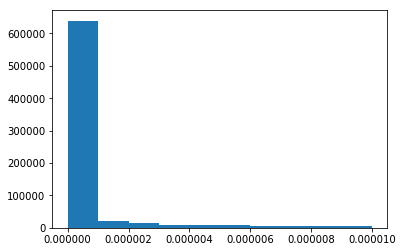

In [52]:
plt.hist(phis[0].values.flatten(), range=(0, 0.00001))

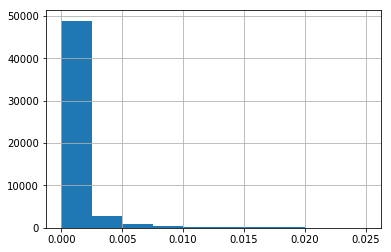

In [40]:
phis[1].sum(axis=1).hist(range=(0, 0.025))

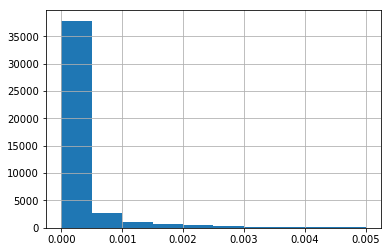

In [20]:
old_words = list(set(phis[0].index))
phis[1].loc[old_words].sum(axis=1).hist(range=(0, 0.005))

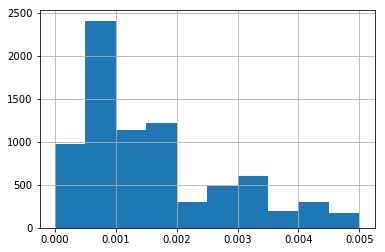

In [21]:
new_words = list(set(phis[1].index) - set(phis[0].index))
phis[1].loc[new_words].sum(axis=1).hist(range=(0, 0.005))

In [23]:
#phis[1][len(phis[0]):].hist(range=(0, 0.025))

## Результаты

### Базовый алгоритм

<p style="color: blue"><b>Без подсчёта когерентности:</b></p>

```
CPU times: user 26min, sys: 58.3 s, total: 26min 58s
Wall time: 25min 44s
```

С подсчётом когерентности:

```
CPU times: user 25min 4s, sys: 40.7 s, total: 25min 45s
Wall time: 26min 29s
```

In [36]:
level0.score_tracker["PerplexityScore"].value[-5:]

[2987.5328278389584,
 2987.1423131676415,
 2986.762812480146,
 2986.4074495146488,
 2986.0881822950705]

In [49]:
print("\n".join([k + ": " + " ".join(v) for k, v in level0.score_tracker["Top10Tokens"].last_tokens.items()]))

topic_8: данные запрос сервер таблица файл база использовать модуль приложение пользователь
topic_13: компания интернет бизнес рынок деньги услуга право клиент реклама товар
topic_2: текст русский словарь буква речь английский символ шрифт предложение языковой
topic_4: безопасность пароль атака защита вирус уязвимость пациент заболевание болезнь метод
topic_11: function return br type data class end code array source
topic_7: значение int функция число код строка алгоритм память байт массив
topic_18: университет научный студент школа образование культура ученый курс знание обучение
topic_15: объект функция класс метод код тип использовать значение int return
topic_6: игра игрок игровой страна рынок уровень экономический экономика играть ход
topic_0: война власть политический страна исторический русский государство историк революция россия
topic_14: клетка ген организм днк вид белок животное растение эволюция молекула
topic_9: изображение элемент кнопка страница файл цвет использовать б

<p style="color: blue"><b>Количество тем, явно связанных с Habrahabr:</b></p>

topic_8, topic_13, topic_4, topic_11, topic_7, topic_15, topic_9, topic_3, topic_10, topic_17, topic_16 — **11 из 19 тем **.

In [17]:
level0.score_tracker["Top10Tokens"].last_coherence

{'topic_0': [0.7033647298812866,
  1.101226806640625,
  0.8233437538146973,
  0.609866201877594,
  0.4848090708255768,
  0.8609563112258911,
  0.9289266467094421,
  0.7955272197723389,
  0.7201809287071228,
  0.5704154968261719],
 'topic_1': [0.9796126484870911,
  1.266061544418335,
  0.18929800391197205,
  0.8204822540283203,
  0.8220633864402771,
  0.7119395732879639,
  1.1802186965942383,
  0.550513744354248,
  0.7388700246810913,
  1.2392897605895996]}

<p style="color: blue"><b>Средняя когерентность:</b></p>

In [18]:
level0.score_tracker["Top10Tokens"].last_average_coherence

0.804848313331604

### Предлагаемый алгоритм (без ранжирования документов)

С подсчётом когерентности:

```
CPU times: user 39min 1s, sys: 34.8 s, total: 39min 36s
Wall time: 31min 34s
```

In [16]:
level0.score_tracker["PerplexityScore"].value[-5:]

[3162.9743869953554, 3159.362220512887, 3157.0215313658773]

In [17]:
print("\n".join([k + ": " + " ".join(v) for k, v in level0.score_tracker["Top10Tokens"].last_tokens.items()]))

topic_13: право закон суд власть политический россия российский авторский отношение лицо
topic_10: устройство плата камера питание экран процессор датчик сигнал корпус частота
topic_0: страна китай китайский война сон япония военный город сша японский
topic_4: клетка ген днк белок cd организм заболевание вирус болезнь make
topic_14: вид растение эволюция ген организм вода животное жить группа земля
background_0: использовать работать пользователь проект приложение данные возможность данный файл создавать
topic_6: компания рынок деньги бизнес цена услуга продажа россия товар проект
topic_12: социальный фильм философия политический пространство отношение общество социология понятие смысл
topic_17: игра игрок играть персонаж герой ход рука голова выходить писать
topic_11: музыка город музыкальный страна германия песня трек государство политический немецкий
topic_15: алгоритм память мозг робот значение нейрон узел задача модель число
topic_2: текст символ перевод русский словарь буква прои

<p style="color: blue"><b>Количество тем, явно связанных с Habrahabr:</b></p>

topic_10, topic_6, topic_15, topic_8, topic_9, topic_16 — **6 из 19 тем**.

<p style="color: blue"><b>Доля тем, связанных с Постнаукой:</b></p>

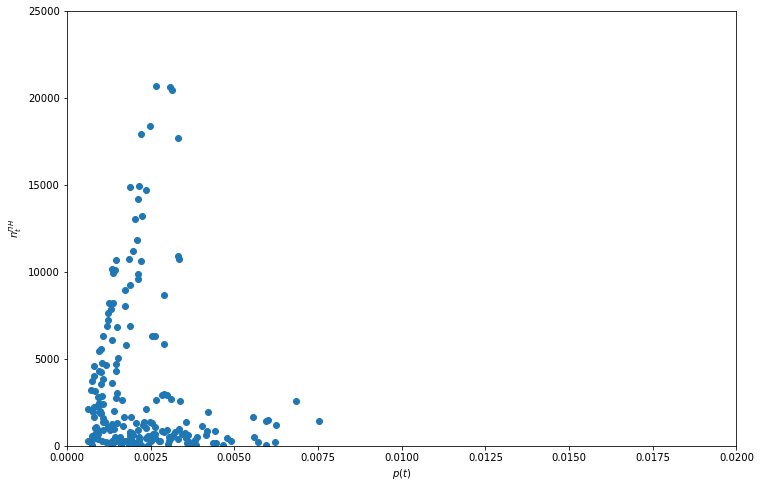

In [16]:
theta0 = level0.get_theta()

docs_lengths_series = pd.Series(docs_lengths)
pn_docs_ids = list(filter(lambda doc_id: doc_id.startswith("pn_"), docs_ids))
n_pn_topics = theta0[pn_docs_ids].dot(docs_lengths_series.loc[pn_docs_ids])
n_topics = theta0.dot(docs_lengths_series)
n_topics /= n_topics.sum()

plt.figure(figsize=(12, 8))
plt.scatter(n_topics[:-1], n_pn_topics[:-1])
plt.xlabel("$p(t)$")
plt.ylabel("$n_t^{ПН}$")
plt.xlim([0, 0.02])
plt.ylim([0, 25000])
plt.show()

In [18]:
level0.score_tracker["Top10Tokens"].last_coherence

{'topic_0': [0.7265726327896118,
  0.9666939973831177,
  0.860042154788971,
  0.9615440368652344,
  0.7932206392288208,
  0.8468619585037231,
  1.1678951978683472,
  0.8162124156951904,
  0.5890388488769531,
  0.9197608232498169],
 'topic_1': [0.7087255120277405,
  0.8550468683242798,
  1.63397216796875,
  0.8533975481987,
  0.6587098836898804,
  1.1358709335327148,
  0.9871459603309631,
  0.8189512491226196,
  0.9011694192886353,
  1.1591038703918457]}

<p style="color: blue"><b>Средняя когерентность:</b></p>

In [19]:
level0.score_tracker["Top10Tokens"].last_average_coherence

0.9179967641830444

### Предлагаемый алгоритм (с ранжированием документов)

<p style="color: blue"><b>Без подсчёта когерентности:</b></p>

```
CPU times: user 22min 6s, sys: 24.8 s, total: 22min 30s
Wall time: 14min 45s
```

С подсчётом когерентности:

```
CPU times: user 45min 15s, sys: 50.7 s, total: 46min 6s
Wall time: 37min 27s
```

In [58]:
level0.score_tracker["PerplexityScore"].value[-5:]

[3148.8859735363003, 3145.2123687869903, 3143.075477042168]

In [59]:
print("\n".join([k + ": " + " ".join(v) for k, v in level0.score_tracker["Top10Tokens"].last_tokens.items()]))

topic_8: игра игрок реклама социальный хороший блог игровой аудитория дизайн идея
topic_13: право закон суд власть политический авторский россия отношение российский государство
topic_2: перевод текст русский символ словарь буква выражение произношение речь английский
topic_4: клетка ген днк белок организм болезнь заболевание вирус пациент молекула
topic_11: музыка музыкальный германия страна песня альбом государство трек политический общество
topic_7: звезда вселенная галактика черный дыра объект излучение волна масса телескоп
topic_18: университет студент школа образование научный знание курс обучение хороший доклад
topic_15: значение алгоритм число функция память результат операция байт точка элемент
topic_6: компания рынок бизнес деньги цена услуга товар россия продажа интернет
topic_0: страна город китай китайский война советский россия япония сша военный
topic_14: вид растение эволюция вода ген организм животное жить земля группа
topic_9: return int класс код метод public объект 

<p style="color: blue"><b>Количество тем, явно связанных с Habrahabr:</b></p>

topic_15, topic_6, topic_9, topic_10 — **4 из 19 тем**.

<p style="color: blue"><b>Доля тем, связанных с Постнаукой:</b></p>

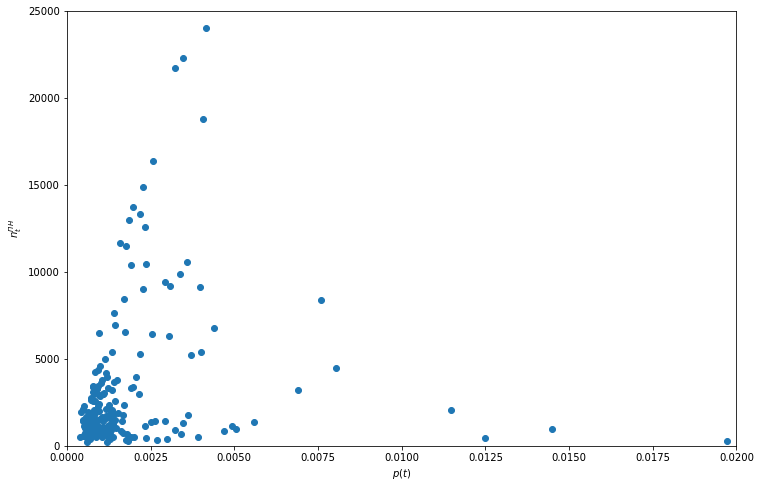

In [64]:
theta0 = level0.get_theta()

docs_lengths_series = pd.Series(docs_lengths)
pn_docs_ids = list(filter(lambda doc_id: doc_id.startswith("pn_"), docs_ids))
n_pn_topics = theta0[pn_docs_ids].dot(docs_lengths_series.loc[pn_docs_ids])
n_topics = theta0.dot(docs_lengths_series)
n_topics /= n_topics.sum()

plt.figure(figsize=(12, 8))
plt.scatter(n_topics[:-1], n_pn_topics[:-1])
plt.xlabel("$p(t)$")
plt.ylabel("$n_t^{ПН}$")
plt.xlim([0, 0.02])
plt.ylim([0, 25000])
plt.show()

In [76]:
level0.score_tracker["Top10Tokens"].last_coherence

{'topic_0': [0.7587596774101257,
  1.223907709121704,
  0.8600420951843262,
  1.0523507595062256,
  0.8620681762695312,
  0.8468619585037231,
  1.0884321928024292,
  0.7912501096725464,
  1.2722722291946411,
  0.9197608232498169],
 'topic_1': [0.7087255120277405,
  0.9577943086624146,
  1.63397216796875,
  0.9011796712875366,
  0.7159020304679871,
  0.7263554930686951,
  0.8448827862739563,
  0.823114812374115,
  0.918533205986023,
  1.0836633443832397]}

<p style="color: blue"><b>Средняя когерентность:</b></p>

In [77]:
level0.score_tracker["Top10Tokens"].last_average_coherence

0.9494915008544922

---